In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
from pytorch_ranger import Ranger 

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5])])

trainset = datasets.MNIST(root='./dataset', train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=250, 
                                          shuffle=True, num_workers=2)



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Now using {} devices".format(device))

Now using cuda devices


In [5]:
# 샘플 이미지 확인하기
real_batch = next(iter(trainloader))
real_batch[0].shape

torch.Size([250, 1, 28, 28])

In [19]:
#변수
nz = 100   #노이즈
lr = 0.0002    #옵티마이저 학습률
beta1 = 0.5   #Adam 옵티마이저의 beta1 하이퍼파라미터
image_size = 1 * 28 * 28  # 이미지 크기
batch_size = 250
n_class = 10
epochs = 20

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(nz + n_class, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(image_size + n_class, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [22]:
D = Discriminator().to(device)
G = Generator().to(device)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = Ranger(D.parameters(), lr = lr)
g_optimizer = Ranger(G.parameters(), lr = lr)

In [48]:
total_step = len(trainloader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.reshape(batch_size, -1).to(device)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(device)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(batch_size, 100).to(device)
        g_label = torch.randint(0, 10, (batch_size,)).to(device)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    print('epoch [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
      .format(epoch,
              epochs,
              d_loss.item(),
              g_loss.item(),
              real_score.mean().item(),
              fake_score.mean().item()))


epoch [0/20] d_loss:0.2535 g_loss: 3.2464 D(x):0.92 D(G(z)):0.06
epoch [1/20] d_loss:0.2228 g_loss: 3.0228 D(x):0.95 D(G(z)):0.08
epoch [2/20] d_loss:0.2530 g_loss: 3.1350 D(x):0.91 D(G(z)):0.03
epoch [3/20] d_loss:0.2522 g_loss: 3.0172 D(x):0.88 D(G(z)):0.03
epoch [4/20] d_loss:0.1980 g_loss: 3.4806 D(x):0.94 D(G(z)):0.06
epoch [5/20] d_loss:0.2683 g_loss: 2.6774 D(x):0.94 D(G(z)):0.11
epoch [6/20] d_loss:0.3981 g_loss: 2.9071 D(x):0.83 D(G(z)):0.04
epoch [7/20] d_loss:0.3983 g_loss: 2.4913 D(x):0.83 D(G(z)):0.04
epoch [8/20] d_loss:0.4035 g_loss: 2.3958 D(x):0.86 D(G(z)):0.07
epoch [9/20] d_loss:0.3795 g_loss: 2.9346 D(x):0.88 D(G(z)):0.09
epoch [10/20] d_loss:0.2839 g_loss: 3.1900 D(x):0.91 D(G(z)):0.08
epoch [11/20] d_loss:0.3816 g_loss: 2.6391 D(x):0.90 D(G(z)):0.12
epoch [12/20] d_loss:0.4310 g_loss: 2.2778 D(x):0.85 D(G(z)):0.11
epoch [13/20] d_loss:0.4370 g_loss: 2.2209 D(x):0.88 D(G(z)):0.15
epoch [14/20] d_loss:0.3487 g_loss: 2.3979 D(x):0.86 D(G(z)):0.09
epoch [15/20] d_loss

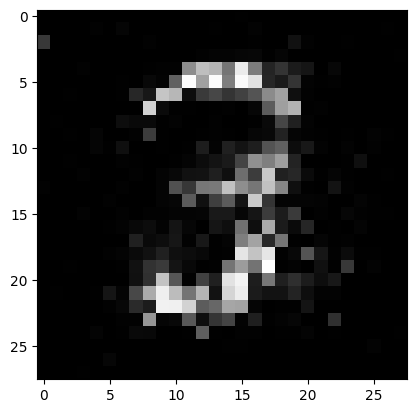

In [47]:
item_number = 2 # 아이템 번호
z = torch.randn(1, 100).to(device) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(device)

sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0],(28,28,1))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()